# Training a FFNN in dCGPANN vs. Keras (regression)

A Feed Forward Neural network is a widely used ANN model for regression and classification. Here we show how to encode it into a dCGPANN and train it with stochastic gradient descent on a regression task. To check the correctness of the result we perform the same training using the widely used Keras Deep Learning toolbox.

In [1]:
# Initial import
import dcgpy
# For plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# For scientific computing and more ...
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle

%matplotlib inline

### Data set

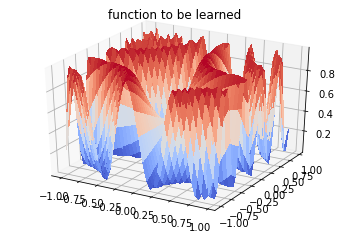

In [2]:
# To plot the unction we use a uniform grid
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
n_samples = len(X) * len(Y)
points = np.zeros((n_samples, 2))

i=0
for x in X:
    for y in Y:
        points[i][0] = x
        points[i][1] = y
        i=i+1
labels = (np.sin(5 * points[:,0] * (3 * points[:,1] + 1.)) + 1. ) / 2.
points = points.reshape((n_samples,2))
labels = labels.reshape((n_samples,1))

# To plot the function 
X, Y = np.meshgrid(X, Y)
Z = (np.sin(5 * X * (3 * Y + 1.)) + 1. ) / 2.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# We shuffle the points and labels
points, labels = shuffle(points, labels, random_state=0)
# We create training and test sets
X_train = points[:800]
Y_train = labels[:800]
X_test = points[800:]
Y_test = labels[800:]
_ = plt.title("function to be learned")

### Encoding and training a FFNN using dCGP

There are many ways the same FFNN could be encoded into a CGP chromosome. The utility *encode_ffnn* selects one for you returning the expression.

Starting error: 0.34546311353140685
Net complexity (number of active weights): 1120
Net complexity (number of unique active weights): 1120
Net complexity (number of active nodes): 73


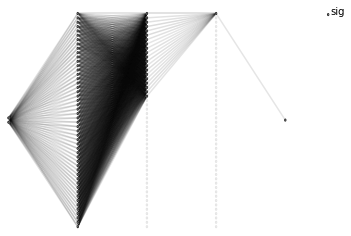

In [3]:
# We define a 2 input 1 output dCGPANN with sigmoid nonlinearities
dcgpann = dcgpy.encode_ffnn(2,1,[50,20],["sig", "sig", "sig"], 5)

std = 1.5
# Weight/biases initialization is made using a normal distribution
dcgpann.randomise_weights(mean = 0., std = std)
dcgpann.randomise_biases(mean = 0., std = std)

# We show the initial MSE
print("Starting error:", dcgpann.loss(X_test,Y_test, "MSE"))
print("Net complexity (number of active weights):", dcgpann.n_active_weights())
print("Net complexity (number of unique active weights):", dcgpann.n_active_weights(unique=True))
print("Net complexity (number of active nodes):", len(dcgpann.get_active_nodes()))
x = dcgpann.get()
w = dcgpann.get_weights()
b = dcgpann.get_biases()
res = []

# And show a visualization of the FFNN encoded in a CGP
dcgpann.visualize(show_nonlinearities=True)

In [4]:
import timeit
start_time = timeit.default_timer()

lr0 = 0.3
for i in tqdm(range(5000)):
    lr = lr0 #* np.exp(-0.0001 * i)
    loss = dcgpann.sgd(X_train, Y_train, lr, 32, "MSE", parallel = 4)
    res.append(loss)
elapsed = timeit.default_timer() - start_time

# Print the time taken to train and the final result on the test set
print("Time (s): ", elapsed)
print("End MSE: ", dcgpann.loss(X_test,Y_test, "MSE"))


100%|██████████| 5000/5000 [00:31<00:00, 158.41it/s]

Time (s):  31.56667455501156
End MSE:  0.01377328855105661


### Same training is done using Keras (Tensor Flow backend)


In [5]:
import keras


Using TensorFlow backend.


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# We define Stochastic Gradient Descent as an optimizer
sgd = optimizers.SGD(lr=0.3)
# We define weight initializetion
initializerw = keras.initializers.RandomNormal(mean=0.0, stddev=std, seed=None)
initializerb = keras.initializers.RandomNormal(mean=0.0, stddev=std, seed=None)

model = Sequential([
    Dense(50, input_dim=2, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(20, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(1, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
])

In [7]:
# For a mean squared error regression problem
model.compile(optimizer=sgd,
              loss='mse')

In [8]:
# Train the model, iterating on the data in batches of 32 samples
start_time = timeit.default_timer()
history = model.fit(X_train, Y_train, epochs=5000, batch_size=32, verbose=False)
elapsed = timeit.default_timer() - start_time

In [9]:
# Print the time taken to train and the final result on the test set
print("Time (s): ", elapsed)
print("End MSE: ", model.evaluate(X_train, Y_train))

Time (s):  125.54014513199218
800/800 [==============================] - 0s 56us/step
End MSE:  0.011436145324259996


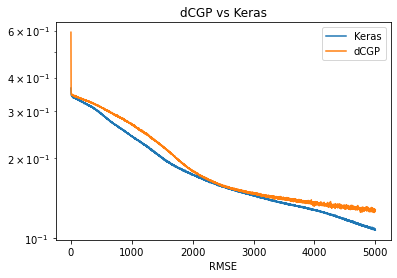

In [10]:
# We plot for comparison the MSE during learning in the two cases
plt.semilogy(np.sqrt(history.history['loss']), label='Keras')
plt.semilogy(np.sqrt(res), label='dCGP')
plt.title('dCGP vs Keras')
plt.xlabel('epochs')
plt.legend()
_ = plt.xlabel('RMSE')

### Repeating ten times the same comparison

100%|██████████| 5000/5000 [00:25<00:00, 195.39it/s]


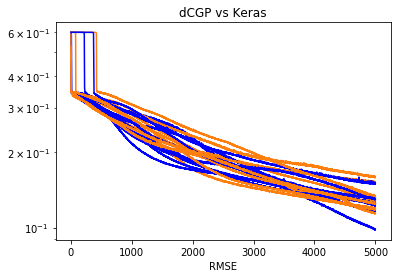

In [12]:
epochs = 5000
for i in range(10):
    # dCGP
    dcgpann = dcgpy.encode_ffnn(2,1,[50,20],["sig", "sig", "sig"], 5)
    dcgpann.randomise_weights(mean = 0., std = std)
    dcgpann.randomise_biases(mean = 0., std = std)
    res = []
    for i in tqdm(range(epochs)):
        lr = lr0 #* np.exp(-0.0001 * i)
        loss = dcgpann.sgd(X_train, Y_train, lr, 32, "MSE", parallel = 4)
        res.append(loss)
    # Keras
    model = Sequential([
        Dense(50, input_dim=2, kernel_initializer=initializerw, bias_initializer=initializerb),
        Activation('sigmoid'),
        Dense(20, kernel_initializer=initializerw, bias_initializer=initializerb),
        Activation('sigmoid'),
        Dense(1, kernel_initializer=initializerw, bias_initializer=initializerb),
        Activation('sigmoid'),
    ])
    model.compile(optimizer=sgd, loss='mse')
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, verbose=False)
    plt.semilogy(np.sqrt(history.history['loss']), color = 'b')
    plt.semilogy(np.sqrt(res), color = 'C1')
plt.title('dCGP vs Keras')
plt.xlabel('epochs')
_ = plt.xlabel('RMSE')
